It seems was have both patients (Diagnosis = 1) and controls (Diagnosis = 0) in this dataset. Let's quickly look how many we have of each

In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil
from sklearn.linear_model import LinearRegression

/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [324]:
# Define biomarkers to input to staging module (make sure they correspond to column titles in the csv)
selected_biomarkers = ['ADAS11','HIPPOCAMPUS_VOLUME','HIPPOCAMPUS_SUVR','CTX_ENTORHINAL_SUVR']

In [325]:
# Define functions 

#  Age regression
def age_regression(biomarker_data, age_data):

    # Reshape age data for sklearn
    X = age_data.values.reshape(-1, 1)
    
    # Initialize model
    model = LinearRegression()
    
    # Container for residuals
    residuals_dict = {}
    
    # Perform regression for each biomarker
    for col in biomarker_data.columns:
        # Get target values, dropping NaN
        y = biomarker_data[col]
        mask = ~(y.isna() | age_data.isna())
        
        if mask.sum() > 0:  # Only perform regression if we have valid data
            # Fit model
            model.fit(X[mask], y[mask])
            
            # Predict for all points
            y_pred = pandas.Series(index=y.index, data=np.nan)
            y_pred[mask] = model.predict(X[mask])
            
            # Calculate residuals
            residuals_dict[col] = y - y_pred
        else:
            residuals_dict[col] = pandas.Series(np.nan, index=y.index)
    
    # Create DataFrame with residuals
    biomarker_data_residuals = pandas.DataFrame(residuals_dict)
    
    return biomarker_data_residuals

# Z-scoring
def z_scoring(biomarker_data, diagnosis_data):

    biomarker_data['DIAGNOSIS'] = diagnosis_data
    
    # extract data for control subjects
    biomarker_data_control = biomarker_data[biomarker_data['DIAGNOSIS'] == 'CN']

    for col in [col for col in biomarker_data.columns if col != 'DIAGNOSIS']:        
        # compute the mean and standard deviation of the control population
        mean_control = biomarker_data_control[[col]].mean()
        std_control = biomarker_data_control[[col]].std()

        # z-score the data
        biomarker_data[[col]] = (biomarker_data[[col]]-mean_control)/std_control

    biomarker_data = biomarker_data.drop('DIAGNOSIS', axis=1)
    return biomarker_data

# For diagnoses 
diagnosis_palette = {
    'AD': '#145A32',  # Deep evergreen
    'MCI': '#9ACD32',       # Yellow-green
    'CN': '#FFFACD'}        # Light yellow/cream

## Pre-Processing Data

In [326]:
# Load data
data = pandas.read_csv('/Users/...Laasya summer project/data/Tau_ADAS_paired_withAgeDX.csv') # Add path to project folder here
data = data.drop(columns=['Unnamed: 0'])

In [328]:
# Process the data! 

# Identify biomarker data from meta data
meta_data = data.iloc[:, :30] # MAKE SURE YOU ARE USING THE RIGHT INDEX
biomarker_data = data.iloc[:, 30:] 

# First, perform age regression on all data
age_data = meta_data['AGE_AT_SCAN']
biomarker_data_age_regressed = age_regression(biomarker_data, age_data)

# Next, correct tau data by cerebellum
tau_data = biomarker_data_age_regressed.loc[:, biomarker_data_age_regressed.columns.str.contains('SUVR')]
tau_data = tau_data.div(tau_data['CEREBELLUM_CORTEX_SUVR'], axis=0)

# Put the corrected tau data back into biomarker_data_age_regressed
biomarker_data_age_regressed.loc[:, biomarker_data_age_regressed.columns.str.contains('SUVR')] = tau_data

# Then z-score all the data
diagnosis_data = meta_data['DIAGNOSIS']
biomarker_data_z_scored = z_scoring(biomarker_data_age_regressed, diagnosis_data)

# Split into different biomarker types and negate volumes
tau_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('SUVR')]
regional_volume_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('VOLUME')] * -1  # Negate volumes after z-scoring
cognitive_score_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('ADAS')]

# Combine all data
combined_data = pandas.concat([meta_data, tau_data, regional_volume_data, cognitive_score_data], axis=1)

# Take only data for the selected biomarkers
processed_data = combined_data[list(meta_data.columns) + list(selected_biomarkers)]
processed_data

,LONIUID,RID,VISCODE_x,SCANDATE,PROCESSDATE,IMAGE_RESOLUTION,qc_flag,TRACER,TRACER_SUVR_WARNING,update_stamp,...,PTHAND,PTMARRY,PTEDUCAT,PTETHCAT,PTRACCAT,AGE_AT_SCAN,ADAS11,HIPPOCAMPUS_VOLUME,HIPPOCAMPUS_SUVR,CTX_ENTORHINAL_SUVR
0,I1594604,21,init,2018-02-02,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,3.0,18.0,2.0,4,85.002053,-0.158089,-0.333452,1.125602,-0.610222
1,I1596177,31,init,2018-04-24,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,2.0,18.0,2.0,5,90.310746,-1.594868,0.677056,-0.103363,-0.093651
2,I1596172,31,y1,2019-04-23,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,2.0,18.0,2.0,5,91.307324,-1.639684,0.896525,-0.053984,-0.108294
3,I1598898,56,init,2018-02-20,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,2.0,13.0,2.0,4,81.973990,-1.579745,0.257640,-0.012954,-0.043957
4,I1598985,56,y1,2019-01-10,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,2.0,13.0,2.0,4,82.861054,0.179240,0.041200,-3.136145,0.070251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,I1053773,6572,bl,2018-09-24,2023-02-17,8mm,-1,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,1.0,13.0,2.0,5,67.980835,-1.069208,NaN,NaN,NaN
1600,I1156588,6697,bl,2019-04-15,2023-02-17,8mm,-1,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,1.0,14.0,2.0,5,61.037645,0.441074,NaN,NaN,NaN
1601,I1186593,6719,bl,2019-05-29,2023-02-17,8mm,-1,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,4.0,15.0,2.0,5,72.320329,1.851301,NaN,NaN,NaN
1602,I1214013,6761,bl,2019-08-06,2023-02-17,8mm,-1,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,1.0,12.0,2.0,5,69.264887,1.031700,NaN,NaN,NaN


## Visualize Biomarker Inputs

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


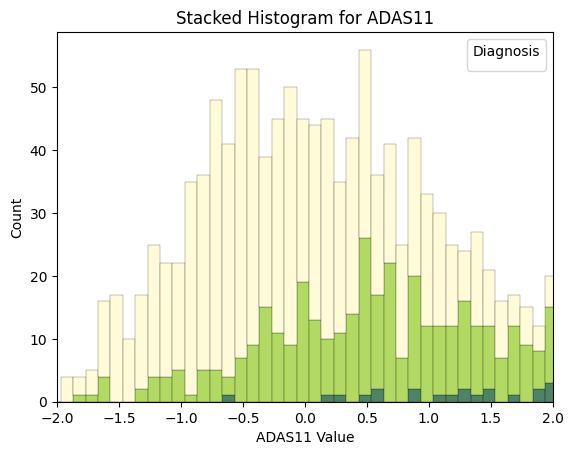

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


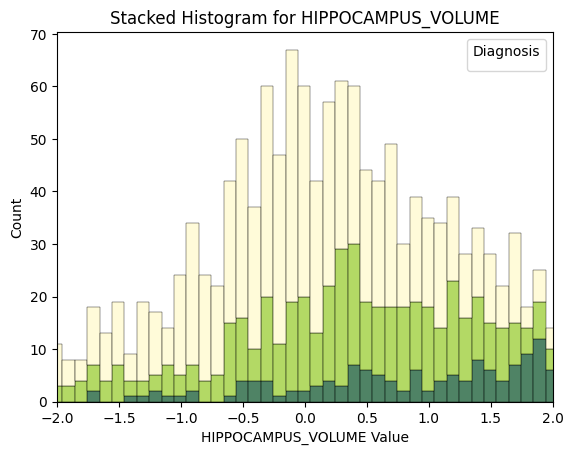

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


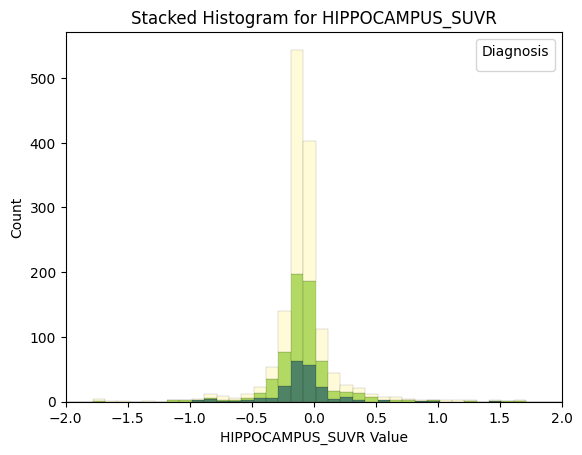

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


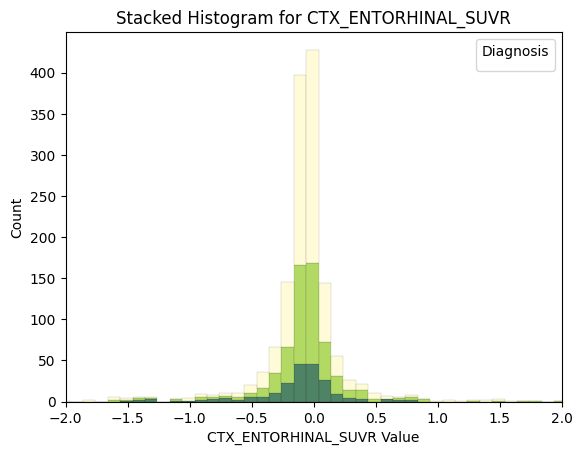

In [329]:
# Plot biomarker histograms check their distributions

for biomarker in selected_biomarkers:
    plt.figure()  # Creates a new figure for each plot
    bin_width = 0.1
    sns.histplot(data=processed_data, x=biomarker, hue='DIAGNOSIS', 
             binwidth=bin_width, multiple='stack', palette=diagnosis_palette)
    plt.title(f'Stacked Histogram for {biomarker}')
    plt.xlabel(f'{biomarker} Value')
    plt.ylabel('Count')
    plt.xlim(-2, 2)
    plt.legend(title='Diagnosis')
    plt.show()

# YOU CAN USE THESE HISTOGRAMS TO INFORM WHAT YOU SET BIOMARKER THRESHOLDS TO

In [ ]:
# First a quick look at the patient and control distribution for one of our biomarkers

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(processed_data,copy=True)

biomarker = selected_biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='DIAGNOSIS',kind='kde',palette=diagnosis_palette)
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

# Prepare Event-based Model Inputs

In [331]:
selected_biomarkers

['ADAS11', 'HIPPOCAMPUS_VOLUME', 'HIPPOCAMPUS_SUVR', 'CTX_ENTORHINAL_SUVR']

In [332]:
N = len(selected_biomarkers) # Number of biomarkers

SuStaInLabels = selected_biomarkers

# ADJUST Z-SCORES FOR EACH BIOMARKER (each row in the array corresponds to a biomarker and each entry is a threshold)
# ie. [0,1,2,3] is the thresholds for 'ADAS1'
# Can choose different numbers of thresholds
Z_vals = np.array([[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3]])
Z_max = np.array([5] * N)  # maximum z-score - set to 5 for each biomarker

In [334]:
# Prepare data for input to SuStaIn

# # First, let's see how many missing values we have in each biomarker
print("Number of missing values per biomarker:")
print(zdata[list(selected_biomarkers)].isnull().sum())

# Remove rows with any missing values in our biomarkers of interest
zdata = zdata.dropna(subset=list(selected_biomarkers))

print("\nShape after removing missing values:", zdata.shape)

# 1. First clean the data
zdata_clean = zdata.dropna(subset=list(selected_biomarkers))

# 2. Check the range of values
print("Data ranges:")
print(zdata_clean[list(selected_biomarkers)].describe())

# 3. Normalize the data to a reasonable range (e.g., z-scores)

# Create normalized version of the data
normalized_data = zdata_clean.copy()
for col in selected_biomarkers:
    normalized_data[col] = stats.zscore(zdata_clean[col])

# Add a small epsilon to prevent zeros
epsilon = 1e-10
normalized_data[list(selected_biomarkers)] = normalized_data[list(selected_biomarkers)].clip(lower=epsilon)

Number of missing values per biomarker:
ADAS11                 0
HIPPOCAMPUS_VOLUME     0
HIPPOCAMPUS_SUVR       0
CTX_ENTORHINAL_SUVR    0
dtype: int64

Shape after removing missing values: (1486, 34)
Data ranges:
            ADAS11  HIPPOCAMPUS_VOLUME  HIPPOCAMPUS_SUVR  CTX_ENTORHINAL_SUVR
count  1486.000000         1486.000000       1486.000000          1486.000000
mean      1.198340            0.378699         -0.022343            -0.026112
std       2.412804            1.270982          1.207663             1.316909
min      -2.169489           -4.954199        -10.975237           -15.663636
25%      -0.380983           -0.416184         -0.152700            -0.148698
50%       0.507046            0.282357         -0.096028            -0.060707
75%       2.038114            1.156795         -0.029326             0.017246
max      18.059758            6.541805         26.594550            27.444724


In [335]:
# Input the settings for SuStaIn (the subtyping and staging algorithm)
N_startpoints = 25 # Recomended: 25
N_S_max = 1 # Number of subtypes
N_iterations_MCMC = int(1e4) # To start use int(1e4), increase this to 1e5 or 1e6
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              normalized_data[selected_biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run the Event-based Model!

In [336]:
# Delete pickle file (SAVE ANY SIGNIFICANT RESULTS FIRST!)
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

In [337]:
# Make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [338]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -8276.261372139132


MCMC Iteration: 100%|██████████| 10000/10000 [00:04<00:00, 2014.82it/s]


In [339]:
# Get model output from pickle file
s = N_S_max - 1 # Which subtype
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# Assess likelihood across MCMC samples
Use to assess the selections of z_vals for each biomarker. Use whichever combination of z_vals maximizes likelihood.

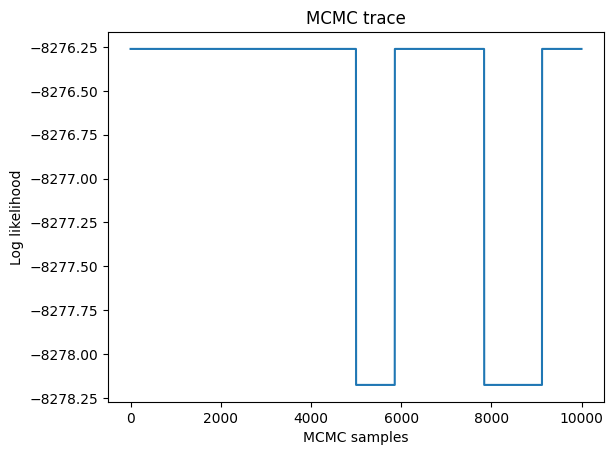

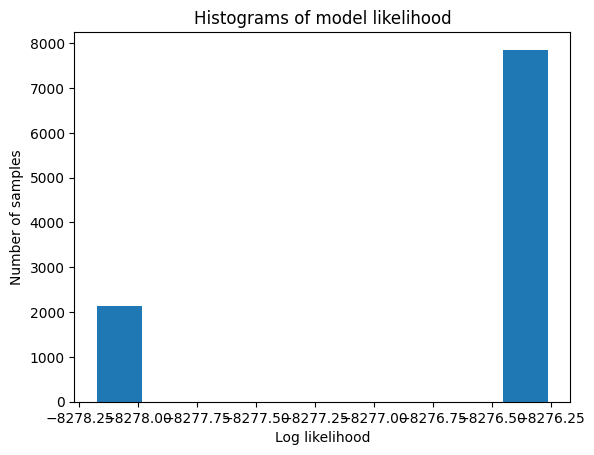

In [340]:
# DONT WORRY ABOUT THIS FOR NOW

for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    #plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    #plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

# Stage individuals

In [341]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

zdata

,LONIUID,RID,VISCODE_x,SCANDATE,PROCESSDATE,IMAGE_RESOLUTION,qc_flag,TRACER,TRACER_SUVR_WARNING,update_stamp,...,PTRACCAT,AGE_AT_SCAN,ADAS11,HIPPOCAMPUS_VOLUME,HIPPOCAMPUS_SUVR,CTX_ENTORHINAL_SUVR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,I1594604,21,init,2018-02-02,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,85.002053,-0.158089,-0.333452,1.125602,-0.610222,0.0,1.0,1.0,0.243336
1,I1596177,31,init,2018-04-24,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,90.310746,-1.594868,0.677056,-0.103363,-0.093651,0.0,1.0,0.0,0.269842
2,I1596172,31,y1,2019-04-23,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,91.307324,-1.639684,0.896525,-0.053984,-0.108294,0.0,1.0,0.0,0.252782
3,I1598898,56,init,2018-02-20,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,81.973990,-1.579745,0.257640,-0.012954,-0.043957,0.0,1.0,0.0,0.292796
4,I1598985,56,y1,2019-01-10,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,82.861054,0.179240,0.041200,-3.136145,0.070251,0.0,1.0,0.0,0.286439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,I1648618,7114,bl,2022-12-06,2023-05-26,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,65.842574,-1.332827,0.476783,-0.081477,-0.049276,0.0,1.0,0.0,0.285611
1513,I10279040,7117,bl,2023-02-07,2023-12-08,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,69.267625,0.070977,0.326873,0.453779,-0.285563,0.0,1.0,0.0,0.264148
1514,I10239398,7121,bl,2023-05-10,2023-09-28,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,62.436687,0.259434,1.458200,-0.283794,-0.438036,0.0,1.0,1.0,0.214025
1515,I10298377,7123,bl,2023-05-18,2024-01-03,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,6,80.459959,0.405942,1.429477,-0.214746,-0.148110,0.0,1.0,1.0,0.215126


In [319]:
# Save zdata to a new file for analysis (make sure to give it a specific name!)
zdata.to_csv('/Users.../Laasya summer project/outputs.csv') # Add the path to your project folder here 

In [342]:
# Count the number of subjects in each stage
zdata.ml_stage.value_counts()

ml_stage
0.0     1003
1.0      160
2.0      125
3.0       51
6.0       42
7.0       35
8.0       24
5.0       22
4.0        9
12.0       5
9.0        5
11.0       4
10.0       1
Name: count, dtype: int64

As a sanity check, let's make sure all the "controls" were given assigned to low stages by SuStaIn

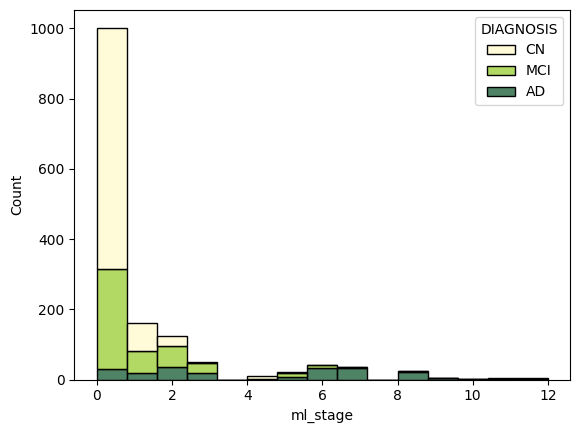

In [343]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments
# ie. AD subjects should be in higher stages and CN in lower stages
sns.histplot(data=zdata, x='ml_stage', hue='DIAGNOSIS', bins=15, multiple='stack', palette=diagnosis_palette)
plt.show()